In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')
folder = '/content/drive/MyDrive/SISS_2'

Mounted at /content/drive


In [ ]:
!pip install volumentations-3D
!pip install SimpleITK

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 48.4 MB 28 kB/s 


In [ ]:
# Model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import SubsetRandomSampler
# Visualization
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
# Image processing
import volumentations as V
import SimpleITK as sitk
# Utils
import tqdm.notebook as tqdm
import scipy.stats as ss

**Visualize**

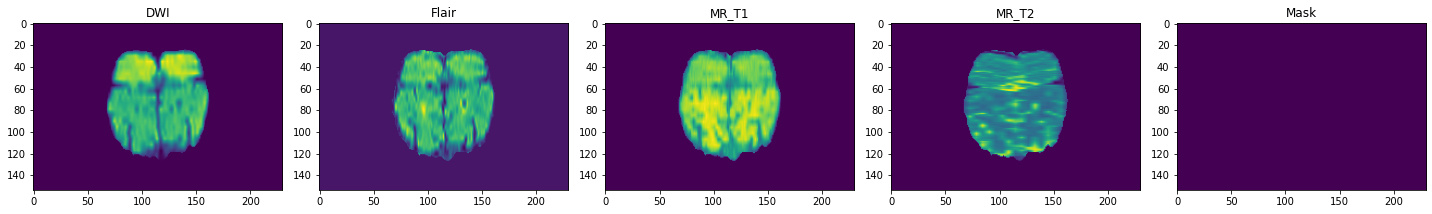

In [ ]:
def visualize_slice(img_idx=7, cut=50, ax=0):
  data = []
  for name in ('DWI', 'Flair', 'MR_T1', 'MR_T2', 'Mask'):
    img = sitk.ReadImage(folder + '/' + name +  '/' + f'{img_idx+1}' + '_' + name + '.nii')
    img = sitk.GetArrayFromImage(img)
    if ax == 0:
      data.append(img[cut, ...])
    elif ax == 1:
      data.append(img[:, cut, :])
    else:
      data.append(img[..., cut])

  fig = plt.figure(figsize=(20, 5))
  axes = []
  curr_col = 1
  for name in ('DWI', 'Flair', 'MR_T1', 'MR_T2', 'Mask'):
    axes.append(fig.add_subplot(1, 5, curr_col))
    axes[-1].set_title(name)
    plt.imshow(data[curr_col - 1])
    curr_col += 1
  fig.tight_layout()
  plt.show()

visualize_slice(img_idx = 15, ax = 1)

**Crop / padding ?**

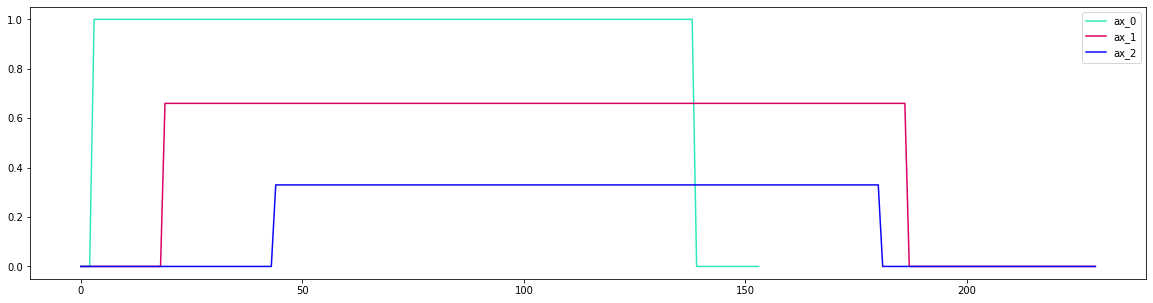

In [ ]:
img = sitk.ReadImage(folder + '/MR_T1/1_MR_T1.nii')
img = sitk.GetArrayFromImage(img)
plt.figure(figsize=(20, 5))
plt.plot([i for i in range(img.shape[0])], (img.sum(axis=(1, 2)) > 0), label='ax_0', color='#2ee8bb')
plt.plot([i for i in range(img.shape[1])], (img.sum(axis=(0, 2)) > 0) * .66, label='ax_1', color='#d90166')
plt.plot([i for i in range(img.shape[2])], (img.sum(axis=(0, 1)) > 0) * .33, label='ax_2', color='#0c06f7')
plt.legend(loc='upper right')
plt.show()

A little more detail:

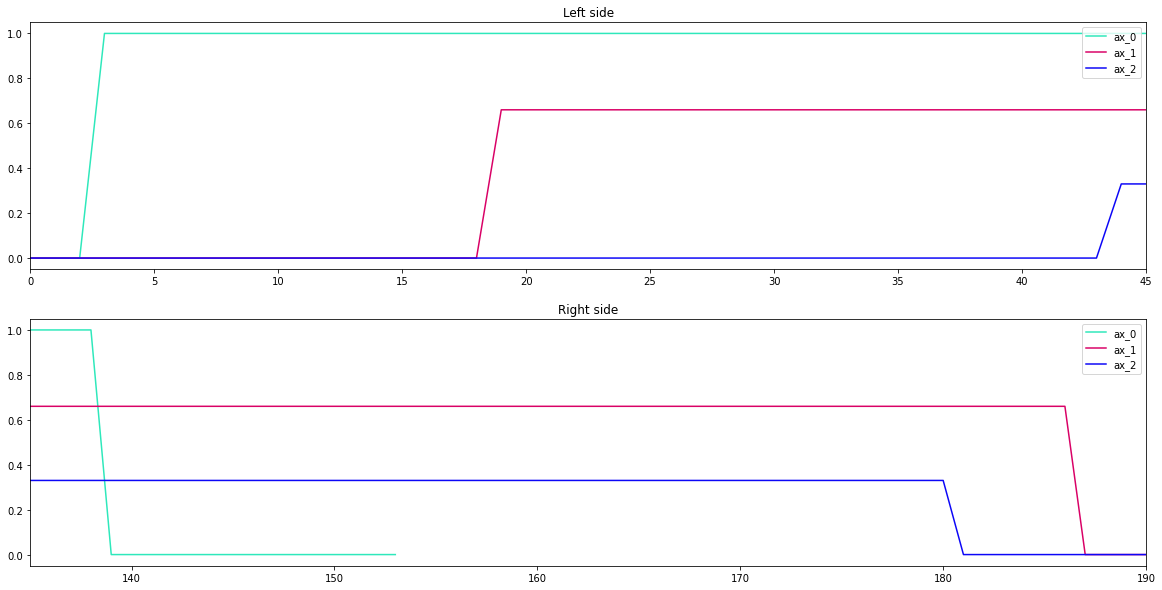

In [ ]:
img = sitk.ReadImage(folder + '/MR_T1/1_MR_T1.nii')
img = sitk.GetArrayFromImage(img)
fig = plt.figure(figsize=(20, 10))
axes = []
axes.append(fig.add_subplot(2, 1, 1))
axes[-1].set_title('Left side')
plt.plot([i for i in range(img.shape[0])], (img.sum(axis=(1, 2)) > 0), label='ax_0', color='#2ee8bb')
plt.plot([i for i in range(img.shape[1])], (img.sum(axis=(0, 2)) > 0) * .66, label='ax_1', color='#d90166')
plt.plot([i for i in range(img.shape[2])], (img.sum(axis=(0, 1)) > 0) * .33, label='ax_2', color='#0c06f7')
plt.legend(loc='upper right')
plt.xlim(0, 45)

axes.append(fig.add_subplot(2, 1, 2))
axes[-1].set_title('Right side')
plt.plot([i for i in range(img.shape[0])], (img.sum(axis=(1, 2)) > 0), label='ax_0', color='#2ee8bb')
plt.plot([i for i in range(img.shape[1])], (img.sum(axis=(0, 2)) > 0) * .66, label='ax_1', color='#d90166')
plt.plot([i for i in range(img.shape[2])], (img.sum(axis=(0, 1)) > 0) * .33, label='ax_2', color='#0c06f7')
plt.legend(loc='upper right')
plt.xlim(135, 190)
plt.show()

So, I'll:

  ax_0: Pad to 160 (32 x 5) 

  ax_1: Crop to 224 (32 x 7)

  ax_2: Crop to 160 (32 x 5)

**Preprocessing and augmentation**

In [ ]:
# Preprocessing
def get_padding(is_train=True):
  if is_train:
    patch_size = (160, 256, 160) # img will be cropped before this
  else:
    patch_size = (160, 256, 256)
  return V.Compose([
      V.PadIfNeeded(shape=patch_size, always_apply=True),
  ], p=1.0)

def get_normalization():
  return V.Compose([
      V.Normalize(always_apply=True)
  ], p=1.0)

# Augmentations
def get_augmentation(p=.5):
  is_apply = ss.bernoulli(p=p).rvs(size=6)
  transforms = []
  #if is_apply[0]:
  #  tf = V.Rotate((-20, 20), (-20, 20), (-20, 20), p=1)
  #  transforms.append(tf)
  if is_apply[1]:
    tf = V.Flip(0, p=1)
    transforms.append(tf)
  if is_apply[2]:
    tf = V.Flip(1, p=1)
    transforms.append(tf)
  if is_apply[3]:
    tf = V.Flip(2, p=1)
    transforms.append(tf)
  if is_apply[4]:
    tf = V.Transpose(axes=(1, 0, 2), p=1)
  if is_apply[5]:
    tf = V.CenterCrop(shape=(128, 128, 128), p=1)
    transforms.append(tf)
  return V.Compose(transforms, p=1)

# Some utils
def use_processing(aug, img):
    data = {'image': img}
    aug_data = aug(**data)
    return aug_data['image']

**Dataset**

In [ ]:
class isles_dataset(Dataset):
  def __init__(self, folder, idxs, padding=None, normalization=True, aug_gen=None, is_train=True):
    self.folder = folder
    self.idxs = idxs
    self.padding = padding
    self.normalization = normalization
    self.aug_gen = aug_gen
    self.is_train = is_train

  def __len__(self):
    return len(self.idxs)

  def __getitem__(self, idx):
    patient_idx = self.idxs[idx]
    data = []
    if self.aug_gen:
      aug = self.aug_gen()
    for name in ('DWI', 'Flair', 'MR_T1', 'MR_T2', 'Mask'):
      img = sitk.ReadImage(folder + '/' + name +  '/' + f'{patient_idx+1}' + '_' + name + '.nii')
      img = sitk.GetArrayFromImage(img)
      if self.is_train:
        img = img[..., 35:190]
      if self.padding:
        img = use_processing(self.padding, img)
      if self.normalization and name != 'Mask':
        img = (img - img.min()) / (img.max() - img.min()) 
      if self.aug_gen: # applies to the image and to the mask
        img = use_processing(aug, img)
      data.append(torch.from_numpy(img[np.newaxis, ...])) # add channel dimension

    image = torch.cat((data[0],data[1], data[2], data[3]), 0)
    seg = data[4]
    
    return image.unsqueeze(0), seg.unsqueeze(0) # add batch dimension
    

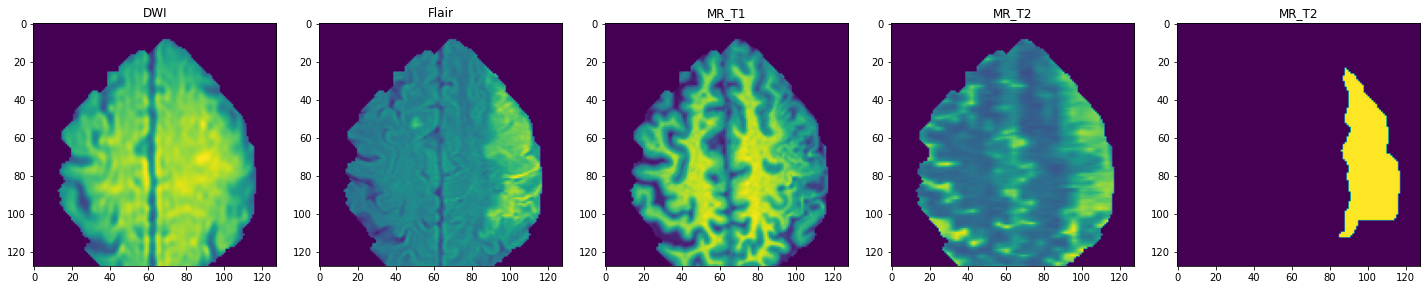

In [ ]:
train_dataset = isles_dataset(folder, [0], padding = get_padding(), normalization = get_normalization(), aug_gen = get_augmentation, is_train = True)
a, b = train_dataset.__getitem__(0)
def visualize_augs(inp_img, seg):
  fig = plt.figure(figsize=(20, 5))
  axes = []
  curr_col = 1
  for name in ('DWI', 'Flair', 'MR_T1', 'MR_T2'):
    axes.append(fig.add_subplot(1, 5, curr_col))
    axes[-1].set_title(name)
    plt.imshow(inp_img[0, curr_col - 1, 100, ...])
    curr_col += 1
  axes.append(fig.add_subplot(1, 5, curr_col))
  axes[-1].set_title(name)
  plt.imshow(seg[0, 0, 100, ...])
  curr_col += 1
  fig.tight_layout()
  plt.show()

visualize_augs(a, b)

**Loss & metric**

In [ ]:
class soft_dice_loss(nn.Module):

  def __init__(self):
    super(soft_dice_loss, self).__init__()
  
  def forward(self, pred_logits, gt, smooth=1.):
    pred = F.sigmoid(pred_logits)
    pred_flat = pred.view(-1)
    gt_flat = gt.view(-1)
    intersection = (pred_flat * gt_flat).sum()
    return 1 - (2. * intersection + smooth) / (pred_flat.sum() + gt_flat.sum() + smooth)

class focal_loss(nn.Module):

  def __init__(self, alpha=.8, gamma=2):
    super(focal_loss, self).__init__()
    self.alpha = alpha
    self.gamma = gamma
  
  def forward(self, pred_logits, gt, smooth=1.):
    pred = F.sigmoid(pred_logits)
    pred_flat = pred.view(-1)
    gt_flat = gt.view(-1)
    bce = F.binary_cross_entropy(pred_flat, gt_flat)
    bce_exp = torch.exp(-bce)
    return self.alpha * (1 - bce_exp) ** self.gamma * bce

class metric_eval():

  def soft_dice_metric(self, pred_logits, gt, smooth=0):
    pred = F.sigmoid(pred_logits)
    pred_flat = pred.view(-1)
    gt_flat = gt.view(-1)
    intersection = (pred_flat * gt_flat).sum()
    return ((2. * intersection + smooth) / (pred_flat.sum() + gt_flat.sum() + smooth)).item()

  def hard_dice_metric(self, pred_logits, gt, smooth=0, threshold=.5):
    pred = F.sigmoid(pred_logits)
    pred_flat = pred.view(-1)
    gt_flat = gt.view(-1)
    intersection = (gt_flat[pred_flat > threshold]).sum()
    hard_dice = (2. * intersection + smooth) / (pred_flat[pred_flat > threshold].sum() + gt_flat.sum() + smooth)
    return hard_dice.item()
  def dice_threshold_curve(self, pred_logits, gt, smooth=0):
    x = [(i * .05) for i in range(1, 21)]
    dice_metrics = []
    for i in range(len(x)):
      dice_metrics.append(self.hard_dice_metric(pred_logits, gt, smooth=smooth, threshold=x[i]))
    plt.figure(figsize=(15, 5))
    plt.plot(x, dice_metrics, marker='o', ls='--')
    plt.xlabel('Threshold')
    plt.ylabel('Hard dice')
    plt.show()

**Help module**

In [ ]:
class model_updater:

  def __init__(self, path='/content/drive/MyDrive/models/', model_name = None):
    self.path = path
    self.model_name = model_name
  
  def new_model(self, model_name = None):
    self.model_name = model_name

  def load_checkpoint(self, model, optimizer):
    checkpoint = torch.load(self.path + self.model_name)
    model.load_state_dict(checkpoint['model_params'])
    optimizer.load_state_dict(checkpoint['optimizer_params'])

    loss_history = checkpoint['loss_history']
    train_history = checkpoint['train_history']
    val_history = checkpoint['val_history']

    return loss_history, train_history, val_history

  def save_checkpoint(self, model, optimizer, loss_history, train_history, val_history):
    checkpoint = {'model_params': model.state_dict(),
                  'optimizer_params': optimizer.state_dict(),

                  'loss_history': loss_history,
                  'train_history' : train_history,
                  'val_history' : val_history}

    torch.save(checkpoint, self.path + self.model_name)

**Train function**

In [ ]:
def train(model, train_loader, val_loader, losses, losses_weights, optimizer, model_updater, device=None, scheduler=None, num_epoch=5):
  loss_history = []
  train_history = []
  val_history = []
  metrics_evaluation = metric_eval()
  if model_updater and model_updater.model_name:
    loss_history, train_history, val_history = model_updater.load_checkpoint(model, optimizer)

  start_epoch = len(loss_history)
  num_samples = 0
  for epoch in range(start_epoch, num_epoch):
    print(f'======== Epoch: {epoch}/{num_epoch} ========')
    print('Training...')

    model.train()

    loss_accumulated = 0
    train_dice_metric = 0

    for i_step, (x, y) in tqdm(enumerate(train_loader)):
      loss_value = 0
      num_samples += y.shape[0]
      if device == 'cuda:0':
        x_gpu = x.to(device)
        y_gpu = y.to(device)
      pred_logits = model(x_gpu)
      for loss, weight in zip(losses, losses_weights):
        loss_value += weight * loss(pred_logits, y_gpu)

      loss_accumulated += loss_value
      train_dice_metric += metric_evalution.soft_dice_metric(pred_logits, y_gpu)
      
      optimizer.zero_grad()
      loss_value.backward()
      optimizer.step()
    
    if scheduler:
      scheduler.step()

    ave_loss = float(loss_accumulated) / num_samples
    loss_history.append(ave_loss) # mean by sample
    train_dice = float(train_dice_metric) / num_samples
    train_history.append(train_dice)
    model.eval()
    print('Validation...')
    val_dice_metric = 0
    num_samples = 0
    for i_step, (x, y) in tqdm(enumerate(val_loader)):
      num_samples += y.shape[0]
      if device == 'cuda:0':
        x_gpu = x.to(device)
        y_gpu = y.to(device)
      pred_logits = model(x_gpu)
      val_dice_metric += metric_evalution.soft_dice_metric(pred_logits, y_gpu)

    val_dice = float(val_dice_metric) / num_samples
    val_history.append(val_dice)

    print(f'Loss: <{round(ave_loss, 4)}>  Train_dice: <{round(train_dice, 4)}>  Val_dice: <{round(val_dice, 4)}>')

    # Save if needed
    if model_updater:
      if val_dice > max(val_history) * .99:
        model_name = f'best_dice_{round(val_dice, 4)}.tar'
        model_updater.new_model(model_name)
        model_updater.save_checkpoint(model, optimizer, loss_history, train_history, val_history)
        print(f'Checkpoint: {model_name}')
      elif (epoch % 5 == 0) and (epoch > 0):
        model_name = f'by_epoch_{epoch}.tar'
        model_updater.new_model(model_name)
        model_updater.save_checkpoint(model, optimizer, loss_history, train_history, val_history)

  return loss_history, train_history, val_history


**Model**

In [ ]:
class 3DUNet(nn.Module):
  pass # TODO

SyntaxError: ignored

**Actually, training**

In [ ]:
# If need to load model
model_name = None
if model_name:
  model_name += '.tar'
# Hyperparams
BATCH_SIZE = 1
NUM_EPOCH = 100
LR = 1e-3
DEVICE = 'cuda:0'
print(torch.cuda.is_available())

In [ ]:
train_indexes = [3, 21, 26, 22, 15, 6, 8, 5, 13, 14, 12, 17, 27, 7, 20, 1, 11, 23, 2, 9, 10, 19, 24]
val_indexes = [4, 18, 16, 0, 25]

train_dataset = isles_dataset(folder, train_indexes, padding = get_padding(), normalization = True, aug_gen = get_augmentation, is_train = True)
val_dataset = isles_dataset(folder, val_indexes, padding = get_padding(is_train=False), normalization = True, is_train = False)

train_sampler = SubsetRandomSampler(train_indexes)

train_loader = DataLoader(train_dataset, batch_size=1, sampler=train_sampler)
val_loader = DataLoader(val_dataset, batch_size=1)

model = 3DUnet(pass) # TODO
model.to(DEVICE)
model.double()

parameters = model.parameters()
optimizer = optim.Adam(parameters, lr=LR)
scheduler = None

updater = model_updater(model_name=model_name)

d_loss = soft_dice_loss()
f_loss = focal_loss()
losses = [d_loss, f_loss]
losses_weights = [.5, .5]

In [ ]:
loss_history, train_history, val_history = train(model=model,
                                                 train_loader=train_loader,
                                                 val_loader=val_loader,
                                                 losses=losses,
                                                 losses_weights=losses_weights,
                                                 optimizer=optimizer,
                                                 model_updater=updater,
                                                 device=DEVICE,
                                                 scheduler=scheduler,
                                                 num_epoch=NUM_EPOCH)

**Check results**